### RETAIL ANALYSIS - INSTANT COFFEE 
Do heavy versus light users in the category have different price elasticities and differences in buying behaviour (e.g., buy different brands, buy different proportion of products on discount)?

To reduce the dimensionality of the problem consider the following retailers: TESCO, ASDA, SAINSBURYS, MORRISSONS and combine the two major discounters ALDI and LIDL (they have similar policies); then focus on the following types: granules, freeze dry, and micro ground.

#### THE DATA
Raw panel data from Kantar Worldpanel containing approx. 270,000 individual level transactions:
    * Relweek  -->  Relative week (209-260)
    * Year  -->  Year of data - 5
    * Shop_Desc  -->  Shop bought (text)
    * Brand_Name  -->  Brand inc Store brand - lower level name (text) 
    * Total_range_name  --> Brand Higher (except store brand) level name (text)
    * Sub_Cat_Name -->  Sub category 
    * Epromdesc	-->  Type of promotion 
    * Volume -->  Volume bought on trip in gms 
    * Household Number  --> Household id
    * Day Of Purchase  -->  day bought (1-7 ) 1=Monday….7=Sunday
    * Packs Bought  -->  No of packs bought 
    * Netspend  -->  Total actual spend on trip ( price paid = netspend / packs) 

#### DELIVERABLES
* Final report: written brief no longer than 2,000 words (excl. references, title page, or index) with up to four pages of appendices.
* The final dataset in the format it was analysed.
* All (clean) scripts used to obtain your final models and analysis.
* Present to Kantar brand manager i.e. non-technical audience (ca. 10min -> 15min w/Q&A).



###### Suggested data manipulations:

1) DEFINING CONSUMER VARIABLES:
* Create ordinal variable for ['heavy', 'medium', 'light'] users: Sum coffee purchase: quantity * frequency
    * 'heavy' upper quartile household_id on average weekly volume
    * 'medium' 2nd-4th quartile household_id on average weekly volume
    * 'light' 1st quartile household_id on average weekly volume
* Distributions of 
    * Household_id net spend OR volume
    * Household_id day they shop


2) COMPUTE ELASTICITY MATRICES:
* Brands
* Types
* Shops
    * household_id gives information on income i.e. zipcode
    * easier: group by shops - assuming households on avg. do their shopping close to their homes


3) A. DEFINING BEHAVIOURAL VARIABLES: PRODUCT
* Proportion of sales being for product that were promoted etc.
* Create dummy variable for promotion of price (eg: promotion in % or cents) vs units (eg: 2 for 1)
    * Epromdesc --> Type of promotion
* ef

3) B. DEFINING BEHAVIOURAL VARIABLES: PREFERENCES
* Analyse prefrences by demographics
* To make a 'long' dataset showing the availability of brands in a shop, look at what other brands where bought in the shop on the same day. (get availability and price)

Do heavy versus light users in the category have different price elasticities and differences in buying behaviour (e.g., buy different brands, buy different proportion of products on discount)?

In [30]:
import csv
import numpy as np
import pandas as pd
import patsy 

%matplotlib inline

# For running regressions and R-type formulas
import statsmodels
import statsmodels.api as sm
# R type regression formulas
import statsmodels.formula.api as smf

df = pd.read_csv('InstantCoffee (confidential).csv')

print len(df)
#df = df.fillna(0)
df = df.dropna()
len(df)

270098


270098

In [12]:
# Get columns headers of data
cols = df.columns.tolist()
cols

['relweek',
 'year',
 'shop_desc',
 'brand_name',
 'total_range_name',
 'sub_cat_name',
 'epromdesc',
 'Volume',
 'HOUSE',
 'DAY',
 'PACKS',
 'NETSPEND']

In [3]:
# Remove unnamed cols and rename remaining cols
#df.drop(df.columns[[6,7,8,9,10,11,12,13]], axis=1, inplace=True)
#cols = ['Week', 'Units', 'Reg_Price', 'Price_Cut', 'DISP', 'FEAT']
#df.columns = cols

In [4]:
# Sort columns in df alphabetically
#cols.sort(key=lambda x:(not x.islower(), x))
#cols
#df = df.ix[:, cols]

In [4]:
df.head(3)

,relweek,year,shop_desc,brand_name,total_range_name,sub_cat_name,epromdesc,Volume,HOUSE,DAY,PACKS,NETSPEND
0,209,5,1TESCO,Nescafe Original I.Coffee,Nescafe,Decaf Non-Freeze Dried,TPR 149p off,0.1999,10052,4,1,4.0
1,209,5,3SAINSBURYS,PL_Standard,Sainsbury,Freeze Dried,2 FOR �5,0.1999,10112,5,1,2.5
2,209,5,3SAINSBURYS,PL_Standard,Sainsbury,Freeze Dried,2 FOR �5,0.1999,10112,5,1,2.5


In [18]:
# How many different coffee types & the list of these
coffee_type = pd.unique(df['sub_cat_name'])
print len(coffee_type), coffee_type

8 ['Decaf Non-Freeze Dried' 'Freeze Dried' 'Granules' 'Micro Ground'
 'Decaf Freeze Dried' 'Speciality Instant Coffee' 'Powder'
 'Chicory Mixtures']


In [36]:
# Only focus on the following types: granules, freeze dry, and micro ground.
# reduced dataset once
df_less_types = df.drop(df[(df.sub_cat_name=='Speciality Instant Coffee') | 
                           (df.sub_cat_name=='Powder') | 
                           (df.sub_cat_name=='Chicory Mixtures')].index)
len(df_less_types)

178409

In [37]:
# How many different shop brands & the list of these
shop_list = pd.unique(df_less_types['shop_desc'])
print len(shop_list), shop_list

17 ['1TESCO' '3SAINSBURYS' '2ASDA' '7DISCOUNTERS Aldi' '7DISCOUNTERS Lidl'
 'X1OTHER B13OTHERS STORES' '4MORRISONS' 'X1OTHER B14OTHERS' '5COOP'
 '6WAITROSE' '8ICELAND' 'X1OTHER B11LOCAL SHOPS'
 'X1OTHER B12OTHER CHEMISTS' 'X1OTHER B10WILKINSON' '9BOOTS'
 'X1OTHER 7SUPERDRUG' '.']


In [39]:
# Only consider the following retailers: TESCO, ASDA, SAINSBURYS, MORRISSONS + combine discounters ALDI and LIDL
# reduced dataset twice
df_less_retailers = df_less_types.drop(df_less_types[(df_less_types.shop_desc=='X1OTHER B13OTHERS STORES') | 
                                                     (df_less_types.shop_desc=='X1OTHER B14OTHERS') |
                                                     (df_less_types.shop_desc=='5COOP') | 
                                                     (df_less_types.shop_desc=='6WAITROSE') |
                                                     (df_less_types.shop_desc=='8ICELAND') | 
                                                     (df_less_types.shop_desc=='X1OTHER B11LOCAL SHOPS') | 
                                                     (df_less_types.shop_desc=='X1OTHER B12OTHER CHEMISTS') | 
                                                     (df_less_types.shop_desc=='X1OTHER B10WILKINSON') | 
                                                     (df_less_types.shop_desc=='9BOOTS') | 
                                                     (df_less_types.shop_desc=='X1OTHER 7SUPERDRUG') | 
                                                     (df_less_types.shop_desc=='.')].index)
len(df_less_retailers)

152868

In [45]:
# Combine Aldi and Lidl into new name == 'DISCOUNTERS'
reduced_df = df_less_retailers.replace(['7DISCOUNTERS Aldi', '7DISCOUNTERS Lidl'], ['DISCOUNTERS', 'DISCOUNTERS'])

,relweek,year,shop_desc,brand_name,total_range_name,sub_cat_name,epromdesc,Volume,HOUSE,DAY,PACKS,NETSPEND
0,209,5,1TESCO,Nescafe Original I.Coffee,Nescafe,Decaf Non-Freeze Dried,TPR 149p off,0.1999,10052,4,1,4.0
1,209,5,3SAINSBURYS,PL_Standard,Sainsbury,Freeze Dried,2 FOR �5,0.1999,10112,5,1,2.5
2,209,5,3SAINSBURYS,PL_Standard,Sainsbury,Freeze Dried,2 FOR �5,0.1999,10112,5,1,2.5


In [46]:
# How many different coffee types & the list of these
coffee_list = pd.unique(reduced_df['brand_name'])
print len(coffee_list), coffee_list

33 ['Nescafe Original I.Coffee' 'PL_Standard' 'Carte Noire' 'Kenco'
 'Douwe Egbert' 'Nescafe Gold Blend(Nestle' 'Nescafe' 'Beanies'
 'Nescafe Alta Rica' 'Maxwell House' 'Cafe Direct (Cafe Direct)' 'PL_Value'
 'Starbucks' 'Rappor' 'Percol Ftrd (Food Brands)' 'Nescafe Black Gold'
 'Nescafe Premium' 'Clipper Fairtrade' 'PL_Premium' 'Nescafe Cap Colombie'
 'Red Mountain (Typhoo Tea)' 'Nescafe Blend 37 (Nestle)'
 'Maxwell House Classic' 'Percol (Food Brands)' 'Cafe Classic' 'Lyons'
 'Nescafe Red Cup I.Coffee' 'Fair Instant' 'Caffe Deli' 'El Careto'
 'Lavazza' 'Other Brands' 'Bewleys']


In [49]:
# How many different coffee brands & the list of these
range_list = pd.unique(reduced_df['total_range_name'])
print len(range_list), range_list

# we might want to group these differently

47 ['Nescafe' 'Sainsbury' 'Carte Noire' 'Kenco' 'Aldi' 'Douwe Egbert'
 'Sainsbury Full Roast' 'Nescafe Gold Blend(Nestle' 'Beanies' 'Lidl'
 'Maxwell House' 'Cafe Direct (Cafe Direct)' 'Tesco Gold'
 'Asda Chosen By You' 'Tesco' 'Morrisons Savers' 'Morrisons' 'Starbucks'
 'Asda Smartprice' 'Tesco Value' 'Tesco Rich Roast' 'Tesco Classic Gold'
 'Rappor' 'Lidl Organic' 'Percol Ftrd (Food Brands)' 'Sainsbury By'
 'Sainsburys Basics' 'Asda Rich Roast' 'Sainsbury Dark Roasted'
 'Clipper Fairtrade' 'Aldi Specially Selected' 'Aldi Fairtrade'
 'Sain Taste The Difference' 'Tesco Finest' 'Red Mountain (Typhoo Tea)'
 'Nescafe Blend 37 (Nestle)' 'Maxwell House Classic' 'Percol (Food Brands)'
 'Cafe Classic' 'Lyons' 'Fair Instant' 'Asda Extra Special' 'Caffe Deli'
 'El Careto' 'Lavazza' 'Other Brands' 'Bewleys']


In [50]:
reduced_df.describe().T

,count,mean,std,min,25%,50%,75%,max
relweek,152868,233.981651,15.150689,209.0000,221.0000,233.00,247.0000,260.0000
year,152868,5.000000,0.000000,5.0000,5.0000,5.00,5.0000,5.0000
Volume,152868,0.163938,0.073050,0.0046,0.1001,0.15,0.1999,0.7501
HOUSE,152868,582529.504501,272061.237900,10052.0000,201341.0000,734862.00,761671.0000,788085.0000
DAY,152868,4.082261,1.911370,1.0000,2.0000,4.00,6.0000,7.0000
PACKS,152868,1.000000,0.000000,1.0000,1.0000,1.00,1.0000,1.0000
NETSPEND,152868,2.920237,1.352321,0.0000,1.9900,2.97,4.0000,14.6300


In [51]:
reduced_df['epromdesc']

0           TPR 149p off
1               2 FOR �5
2               2 FOR �5
3           TPR 164p off
4           TPR 300p off
5           No Promotion
6           No Promotion
7           TPR 095p off
8           TPR 095p off
9         50% Extra Free
10        50% Extra Free
11          No Promotion
12          TPR 238p off
13          TPR 238p off
14          TPR 119p off
15          TPR 100p off
19          TPR 238p off
20          No Promotion
21          No Promotion
22          No Promotion
23          No Promotion
24          TPR 148p off
25          TPR 148p off
26          TPR 238p off
29          No Promotion
31          TPR 095p off
32          TPR 095p off
33          TPR 095p off
37          TPR 149p off
38          TPR 149p off
               ...      
270063      TPR 058p off
270064      TPR 149p off
270066      TPR 199p off
270067      TPR 299p off
270068      TPR 299p off
270069      TPR 200p off
270070      TPR 099p off
270071      No Promotion
270072      TPR 350p off


In [10]:
# Coffee - Regressions

# Design matrices (endog & exog)
# http://statsmodels.sourceforge.net/devel/gettingstarted.html

#cols = ['Week', 'Units', 'Reg_Price', 'Price_Cut', 'DISP', 'FEAT']

# Linear model
y1, X1 = patsy.dmatrices('Units ~ Reg_Price + Price_Cut', data=df, return_type='dataframe')

# Semi-log model
#y2, X2 = patsy.dmatrices('np.log(Units) ~ Reg_Price + Price_Cut', data=df, return_type='dataframe')

# Log-log model
#y3, X3 = patsy.dmatrices('np.log(Units) ~ np.log(Reg_Price) + np.log(Price_Cut)', data=df, return_type='dataframe')

mod1 = sm.OLS(y1, X1)    # Describe linear model
res1 = mod1.fit()       # Fit linear model

#mod2 = sm.OLS(y2, X2)    # Describe semi-log model
#res2 = mod2.fit()       # Fit semi-log model

#mod3 = sm.OLS(y3, X3)    # Describe log-log model
#res3 = mod3.fit()       # Fit log-log model

# Change number to select which model to print summary of
print res1.summary()

                            OLS Regression Results                            
Dep. Variable:                  Units   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     54.23
Date:                Sat, 05 Mar 2016   Prob (F-statistic):           2.92e-14
Time:                        09:19:14   Log-Likelihood:                -585.88
No. Observations:                  64   AIC:                             1178.
Df Residuals:                      61   BIC:                             1184.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   3.668e+04   7610.283      4.820      0.0

In [13]:
# Calculating price elasticities
# Linear model
price1_elas = res1.params[1]*np.mean(df['Reg_Price'])/np.mean(df['Units'])
# Semi-log model
#price2_elas = res2.params[1]*np.mean(df['Reg_Price'])
# Log-log model
#price3_elas = res3.params[1]

print "price elasticity from linear model: ", price1_elas
#print "price elasticity from semi-log model: ", price2_elas
#print "price elasticity from log-log model: ", price3_elas

price elasticity from linear model:  -3.54891729892


### COFFEE REGRESSIONS: Estimating Demand

#### Linear model: Units (oz) = 3669 - 77.631 Reg_Price + 279.187 Price_Cut

* Price elasticity = beta_1 * Pi/Qi (->take the mean of these)
    *              = -3.549
* Adj-R.sq = 0.640
* Price t-Stat = -3.854
* Price_Cut t-Stat = 9.764


#### Other models

Semi-log model:
Adj-R.sq = 0.508

Log-log model:
Adj-R.sq = 
Price t-Stat =

In [18]:
# Regression Including marketing values
y4, X4 = patsy.dmatrices('Units ~ Reg_Price + Price_Cut + DISP + FEAT', data=df, return_type='dataframe')

mod4 = sm.OLS(y4, X4)    # Describe model
res4 = mod4.fit()       # Fit model
print res4.summary()   # Summarize model

                            OLS Regression Results                            
Dep. Variable:                  Units   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     103.7
Date:                Sat, 05 Mar 2016   Prob (F-statistic):           5.44e-26
Time:                        09:27:39   Log-Likelihood:                -551.91
No. Observations:                  64   AIC:                             1114.
Df Residuals:                      59   BIC:                             1125.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.806e+04   4659.428      6.022      0.0

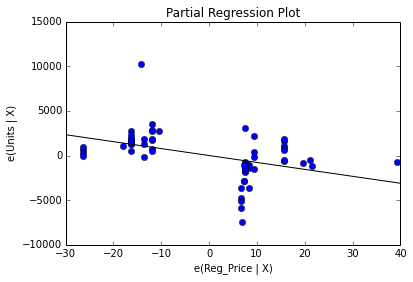

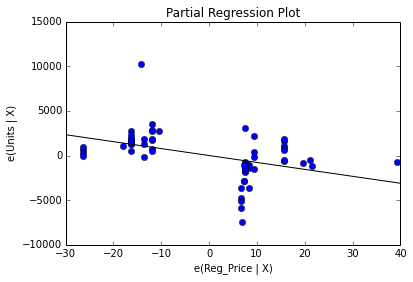

In [26]:
sm.graphics.plot_partregress('Units', 'Reg_Price', ['Price_Cut'], data=df, obs_labels=False)
# sm.graphics.plot_partregress('np.log(Units)', 'Reg_Price', ['Price_Cut'], data=df, obs_labels=False)
# sm.graphics.plot_partregress('np.log(Units)', 'np.log(Reg_Price)', ['Price_Cut'], data=df, obs_labels=False)

#### So which is the best model?
 * We recomputed the Sum of Squared Errors for all the models by predicting units 
     (we take the exponential of the predictions of the models using log units as dependent variable)
 * To get an idea of size of the error take the square root of that and divide by the number of observations and now it is no longer clear that the non-linear models are really so much better
 * Other diagnostics are also useful (e.g. look at the errors)
 
 
#### Get better results by including: 
 * Marketing Variables: Feature and Display are also called “quality discounts” because they are usually more noticeable and case greater lift)
 * Competitive Effects: Cross-effects i.e. how the actions of others impact our sales

In [ ]:
obs = sm.regression.linear_model.RegressionResults.nobs(res)

# Sum of squared residuals (also known as the Sum of Squared Errors) 
#    -> the lower the better: use to compare models
ssr = sm.regression.linear_model.RegressionResults.ssr(res)
np.sqrt(ssr)/obs

# Total mean squared error. 
# Defined as the uncentered total sum of squares divided by n the number of observations.
#sm.regression.linear_model.RegressionResults.mse_total(res)

# Mean squared error of the residuals. 
# The sum of squared residuals divided by the residual degrees of freedom.
#sm.regression.linear_model.RegressionResults.mse_resid(res)

# sm.regression.linear_model.RegressionResults.fittedvalues(res)

### Calculating cross price elasticities of Detergent1 on the remaining 3

Cross-Price Elasticity Example:
Competitor j lowers price by 10 percent, our volume declines by 5 percent
The cross-price elasticity of our sales with respect to competitor j’s price is 5/10 = 0.50
Interpretation: if our competitor increases price by 1% we will increase our units sold by 0.5%


In [17]:
# We use the linear model
y4, X4 = patsy.dmatrices('Units ~ Reg_Price + Price_Cut + DISP + FEAT', data=df, return_type='dataframe')
                         
mod4 = sm.OLS(y4, X4)    # Describe model
res4 = mod4.fit()       # Fit model
print res4.summary()   # Summarize model

                            OLS Regression Results                            
Dep. Variable:                  Units   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     103.7
Date:                Sat, 05 Mar 2016   Prob (F-statistic):           5.44e-26
Time:                        09:27:00   Log-Likelihood:                -551.91
No. Observations:                  64   AIC:                             1114.
Df Residuals:                      59   BIC:                             1125.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   2.806e+04   4659.428      6.022      0.0

In [ ]:
# Computations of elasticities are exactly the same as before except now we use the mean of Pi and Qi
# of the competing brand.
res4.params

#### Elasticity Matrix

In [ ]:
# For a semi-log model
own_price_elas = res4.params[1] * np.mean(df['PRICE1'])
cross_elas1_on_2 = res4.params[1] * np.mean(df['PRICE2'])
cross_elas1_on_3 = res4.params[1] * np.mean(df['PRICE3'])
cross_elas1_on_4 = res4.params[1] * np.mean(df['PRICE4'])

# This would be the first column of the cross price elasticity
#vol.extend(value for name, value in locals().items() if name.startswith('volume'))
col_1 = [own_price_elas, cross_elas1_on_2, cross_elas1_on_3, cross_elas1_on_4]
col_1

### Clout and Vulnerability